# 3. Experiments

In [ ]:
from environments import MontyHallEnv, MontyHallDiscreteWrapper
from src.rl import QLearningConfig, QLearningAgent

import os
import gymnasium as gym
import wandb
import numpy as np
import matplotlib.pyplot as plt

# Environments defined with Gymnasium
Recall that Reinforcement Learning needs an environment to act in. It takes actions in this environment, learning what the optimal action is for each environment state it observes based on a reward it receives. Environments are independent of the algorithm being used.

`Gymnasium` (https://gymnasium.farama.org/index.html) is the most popular library for defining environment classes and provides a lot of helpful wrappers, as well as an unified and clearly defined interface that all environments follow. It is a fork (continuation) of OpenAI's `Gym`, note that the original `Gym` is no longer maintained by anyone. Sometimes, people refer to `Gym` when they mean `Gymnasium` as a shorthand, or in older posts/literature used `Gym` when it was the main library.

Here, we intend to run the environment initially, to get a feel for how our implemented algorithm (Tabular Q Learning) works in practice with the Gymnasium interface on a provided environment, Monty Hall.

# Monty Hall environment
The Monty Hall is a well-known problem that originated from a game show, it can be stated as follows:
> Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a car; behind the others, goats. You pick a door, say No. 1, and the host, who knows what's behind the doors, opens another door, say No. 3, which has a goat. He then says to you, "Do you want to pick door No. 2?" Is it to your advantage to switch your choice?

<p align="center">
  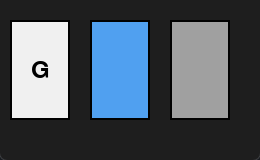
</p> 

Overall in this notebook, our aim is to learn whether it is optimal or not to actually switch or remain. We can see this by rolling out our policy.

You can also play this environment yourself in the notebook: `notebooks/extra/play_monty_hall.ipynb` before proceeding here.

## Creating the configuration for the algorithm, an agent class, and instantiating the environment

In [ ]:
# 1) Let us create a default config and default Q Learning Agent
config = QLearningConfig(
    learning_rate=0.1,
    discount_factor=0.99,
    epsilon_start=1.0,
    epsilon_decay=0.9985,
    epsilon_min=0.05,
    max_steps_per_episode=100,
    video_dir="exports/monty_hall",
)

# 2) Create an instance of the Monty Hall environment
env = gym.make(
    "MontyHall-v0",
    n_doors=3,
    n_cars=1,
    render_mode="rgb_array",
)

# 2a) Tabular Q Learning requires a Discrete action space: not MultiDiscrete
env = MontyHallDiscreteWrapper(env)

# 3) An instance of Tabular Q Learning
agent = QLearningAgent(env, config)

# 4) Train for 500 episodes
num_episodes = 500
episode_rewards, converged_episode, converged_time = agent.train(
    episodes=num_episodes,
    log_interval=10,
)

# 4) Print out what happened each episode
for i, r in enumerate(episode_rewards, start=1):
    print(f"Episode {i:2d} → Reward: {r:+.1f}")

if converged_episode != -1:
    print(f"\nConverged at episode {converged_episode} after {converged_time:.2f}s")
else:
    print("\nDid not converge within 10 episodes.")

# 5) See the policy
print("\nRunning 10 test episodes with the trained policy:")
agent.test(episodes=10)

env.close()

# Visualisation of Training
Here, we want to visualise how well our training went in terms of the reward achieved throughout the episodes encountered by our training algorithm. The best way to do this is quite simple: plot the training so far.

In [ ]:
dpi     = 120       # figure resolution

r = np.asarray(episode_rewards, dtype=float)

cumsum = np.cumsum(np.insert(r, 0, 0))
smooth = (cumsum[num_episodes:] - cumsum[:-num_episodes]) / num_episodes
episodes_smooth = np.arange(len(smooth)) + num_episodes//2 + 1

plt.figure(figsize=(10, 5), dpi=dpi)
plt.plot(range(1, len(r) + 1), r, alpha=0.25, label='Episode reward')

plt.title('Training Performance: Episode Rewards', fontsize=14)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Hyperparameter tuning
Some Reinforcement Learning algorithms have an abundance of parameters; especially in the territory of Deep Reinforcement Learning, where you could tune the batch size and even the neural network layout, amongst the learning rate and exploration rate.

Therefore, it is important that we are able to systematically tune these hyperparameters in an automated fashion, as the number of combinations of parameters and interdependent effects are too numerous to manually tune (aside from setting a good starting point). Tuning is an art in and of itself, and is a form of optimization. Luckily, many libraries exist for finding the optimal set of hyperparameters, using various different approaches such as genetic algorithms, in order to explore and exploit areas of the tuning state space that are promising automatically.

## How does it work?
Exactly how hyperparameter tuning chooses to select combinations of parameters, continue runs (also known as *sweeps*, each sweep having an unique combination of parameters) or stop early, is an art in and of itself. There are many methods and algorithms that are out of scope for this project, although it should be noted that we are not simply enumerating all possible parameters as in a grid search, for example instead we can choose to use a random search or Bayes search.

What we define is a tunable parameter, such as the following:
```python
        learning_rate   = dict(min=1e-5,  max=1e-2,  distribution="log_uniform_values"),
```
* **What it is:** a rule for the hyperparameter tuning library, stating it should *try out different learning-rates* during a hyperparameter sweep.
* **The range:** it may pick anything between **0.00001** and **0.01**.
* **How the picks are made:** not evenly spaced, but **log-uniformly**.

  * Think “pick a random exponent” rather than “pick a random number.”
  * Each order of magnitude (10⁻⁵ → 10⁻⁴ → 10⁻³ → 10⁻²) is equally likely.

Why log-uniform?

1. With learning rates, what matters is usually the *order of magnitude*, not the exact decimal.
2. A log-uniform draw therefore spends just as much effort exploring tiny values (which often work best) as it does larger ones.

In short: *“Try lots of learning-rates between 0.000 01 and 0.01, giving every magnitude the same chance, because we don’t yet know which size step the optimiser will like.”*

This is just one tunable parameter, and the problem of hyperparameter tuning is you have to select values for multiple hyperparameters at the same time, where hyperparameters are not always independent of each other, and you have limited compute time to run these experiments in. This is why specialised algorithms exist just for hyperparameter tuning.

## Why is hyperparameter tuning needed?
Finding the best set of hyperparameters allows converging (achieving the optimal/best performance) in a quicker fashion. It is possible that a default set of hyperparameters could converge to an optimal policy, but take 1000 times longer than using a set of optimal hyperparameters. Sometimes, without optimal hyperparameters it can also be easy for the policy to appear it has converged but it has converged to a sub-optimal policy instead of the policy that produces the best reward.

## Weights and Biases
Weights and Biases (referred to commonly as W&B or WandB) is a standard tool used in both industry and academia for tracking (and storing) the results of experiments. In other words, Weights and Biases is an end-to-end developer platform that keeps every experiment, dataset, model checkpoint, and evaluation in a single, searchable workspace.

Specifically, we use it both as a hyperparameter tuning library and storing the results of experiments based on these hyperparameters.

You can find more information at: https://docs.wandb.ai/quickstart/

In [ ]:
wandb.login() # See https://docs.wandb.ai/quickstart/

In [ ]:
def train_sweep() -> None:
    """  One full training run driven by a set of hyper-parameters coming
    from wandb.config. Logs metrics to W&B at the end of every episode.
    """
    with wandb.init(project="montyhall-ql") as run:
        cfg = run.config

        # 1. Converting the Weight & Biases Config -> Q Learning Config
        qcfg = QLearningConfig(
            learning_rate   = cfg.learning_rate,
            discount_factor = cfg.discount_factor,
            epsilon_start   = 1.0,
            epsilon_decay   = cfg.epsilon_decay,
            epsilon_min     = 0.05,
            max_steps_per_episode = 100,
            video_dir       = None
        )

        # 2️) Create env & agent
        env  = gym.make("MontyHall-v0", n_doors=3, n_cars=1, render_mode=None)
        env  = MontyHallDiscreteWrapper(env)
        agent = QLearningAgent(env, qcfg)

        # 3️) Run training loop
        episode_rewards, converged_ep, converged_t = agent.train(
            episodes     = 500,
            log_interval = 25,
        )

        # 4️) Log summary metrics & clean up
        wandb.log({
            "best_reward"      : max(episode_rewards),
            "converged_episode": converged_ep,
            "train_time_sec"   : converged_t,
        })
        env.close()

In [ ]:
sweep_config = dict(
    name   = "montyhall-bayes",
    method = "bayes",                      # The search method used: grid | random | bayes. Random & Bayes work best.
    metric = dict(name="best_reward", goal="maximize"),
    parameters = dict(
        learning_rate   = dict(min=1e-5,  max=1e-2,  distribution="log_uniform_values"),
        discount_factor = dict(min=0.8,   max=0.999, distribution="uniform"),
        epsilon_decay   = dict(min=0.95,  max=0.9999,distribution="uniform"),
    ),
    early_terminate = dict(type="hyperband", min_iter=10),
)

sweep_id = wandb.sweep(sweep_config, project="montyhall-ql")
wandb.agent(sweep_id, function=train_sweep, count=30) # 30 trials

# Viewing the results
If you navigate to the sweep URL on Weights & Biases (wandb.ai), you'll see the data logged in various formats such as table and graphs, where you can visualise the hyperparameter space. You should see something like the following:

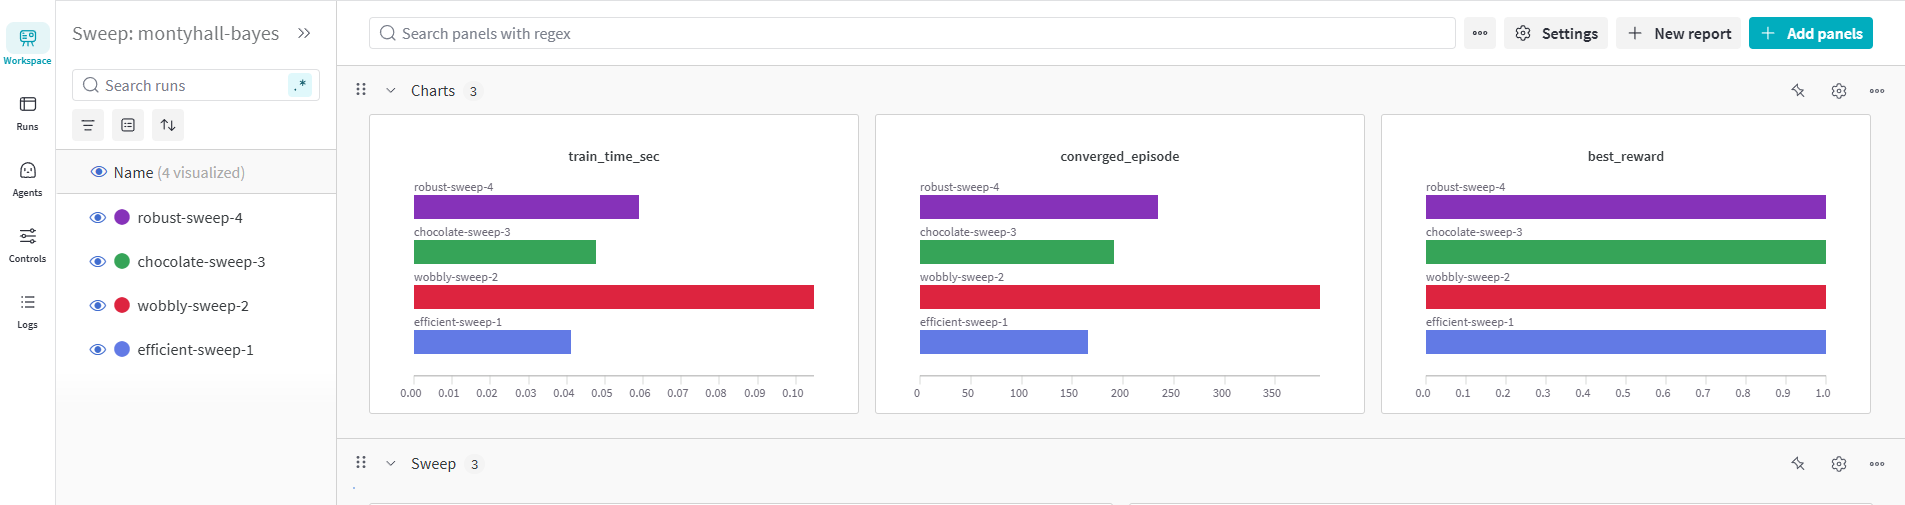

Explore this dashboard fully for more information on how the tuning and sweeps went.

We can programmatically print the best hyperparameters as below:

In [ ]:
api   = wandb.Api()
sweep = api.sweep(f"{os.getenv("WANDB_ENTITY")}/montyhall-ql/{sweep_id}")
best  = max(sweep.runs, key=lambda r: r.summary.get("best_reward", float("-inf")))



# ── 2. Rank runs: highest reward FIRST, then earliest convergence ────────
def sort_key(run):
    # Reward: want *larger* → negate so larger becomes “smaller” for sort()
    reward = -run.summary.get("best_reward", float("-inf"))
    # Convergence episode: want *smaller*
    conv_ep = run.summary.get("converged_episode", float("inf"))
    return (reward, conv_ep)

best_run = min(sweep.runs, key=sort_key)

# ── 3. Print the winner’s details ────────────────────────────────────────
print(f"🏆  {best_run.name}")
print(f"   • best_reward       : {best_run.summary['best_reward']}")
print(f"   • converged_episode : {best_run.summary['converged_episode']}")
print(f"   • hyperparams:", {k: best_run.config[k] for k in ('learning_rate',
                                                    'discount_factor',
                                                    'epsilon_decay')})

# Conclusion

In this notebook, we learnt the following:
* Instantiating environments with the Gymnasium library
* Deployed our previously implemented Reinforcement Learning algorithm, Tabular Q Learning, on the aforementioned environment 
* How to visualise training performance through plotting with Matplotlib
* How to perform hyperparameter tuning
* Followed best practices for experiment tracking and storage of results in an archival manner

Following this notebook, we will learn the process of environment creation in Notebook 4. This allows solving any arbitrary combinatorial problem, allowing you to formally define a model of the "problem space" for any problem you can think of.

# Extension
---

## Extension 1. Optimal General Solution to Monty Hall
As an extension to this, you can consider the following task:
> Based on our trained RL algorithm, using optimal hyperparameters above, how often is it optimal to switch or stay with the first selected door? 

You can do this by using the `.test()` method and collecting some basic statistics using the rolled-out policy.